In [1]:
import pandas as pd 

DATAPATH = "../data/processed/cleaned_data.csv"

In [2]:
df = pd.read_csv(DATAPATH)
df.head()

,HourUTC,HourDK,PriceArea,ConsumerType_DE35,TotalCon
0,2023-06-30 21:00:00,2023-06-30 23:00,DK1,111,65920.0
1,2023-06-30 21:00:00,2023-06-30 23:00,DK2,111,47018.0
2,2023-06-30 21:00:00,2023-06-30 23:00,DK1,112,1313.0
3,2023-06-30 21:00:00,2023-06-30 23:00,DK2,112,933.0
4,2023-06-30 21:00:00,2023-06-30 23:00,DK1,119,21806.0


# Preprocess Data

In [6]:
df = df.dropna()

In [7]:
df['TotalCon'] = df['TotalCon'].astype(int)

In [8]:
df.head()

,HourUTC,HourDK,PriceArea,ConsumerType_DE35,TotalCon
0,2023-06-30 21:00:00,2023-06-30 23:00,DK1,111,65920
1,2023-06-30 21:00:00,2023-06-30 23:00,DK2,111,47018
2,2023-06-30 21:00:00,2023-06-30 23:00,DK1,112,1313
3,2023-06-30 21:00:00,2023-06-30 23:00,DK2,112,933
4,2023-06-30 21:00:00,2023-06-30 23:00,DK1,119,21806


## Reshape $y\hat{}$

In [9]:
# Assuming your DataFrame is named 'df'
column = df['PriceArea']

# Reshape the column into (-1, 1)
reshaped_column = column.values.reshape(-1, 1)

In [10]:
reshaped_column

array([['DK1'],
       ['DK2'],
       ['DK1'],
       ...,
       ['DK2'],
       ['DK1'],
       ['DK1']], dtype=object)

## Categorical Encoding

In [11]:
from sklearn.preprocessing import OrdinalEncoder

# Create an instance of the OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(reshaped_column)

In [12]:
encoded_data

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]])

# Model Selection Condition 
## Check Stationary of Dataset (Unit Root Testing) 

* Follow this guide: https://stackoverflow.com/questions/63517126/any-way-to-predict-monthly-time-series-with-scikit-learn-in-python

* Unit Root Testing: http://bashtage.github.io/arch/doc/unitroot/unitroot_examples.html


TLDR: Check if the data is unpredictable or not

## KPSS 
#### TODO: Check if valid KPSS assumptions

#### Testing  

In [13]:
from arch.unitroot import KPSS

In [14]:
kpss_test = KPSS(df['TotalCon'])

In [16]:
print(kpss_test.summary().as_text())

    KPSS Stationarity Test Results   
Test Statistic                  7.111
P-value                         0.000
Lags                             2298
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


## ADF

Ref: http://bashtage.github.io/arch/doc/unitroot/unitroot_examples.html

#### TODO: Check if valid ADF assumptions

#### Testing

In [19]:
from arch.unitroot import ADF

adf = ADF(df['TotalCon'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -28.932
P-value                         0.000
Lags                              126
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/arch/unitroot/unitroot.py:776: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


# Baseline Model

## Load & Setup Dataset 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt  
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

DATA_PATH = "../data/processed/cleaned_data_30Sep2023.csv" 
df = pd.read_csv(DATA_PATH)
df.head()

,HourUTC,HourDK,PriceArea,ConsumerType_DE35,TotalCon
0,2023-06-30 21:00:00,2023-06-30 23:00,DK1,111,65920.0
1,2023-06-30 21:00:00,2023-06-30 23:00,DK2,111,47018.0
2,2023-06-30 21:00:00,2023-06-30 23:00,DK1,112,1313.0
3,2023-06-30 21:00:00,2023-06-30 23:00,DK2,112,933.0
4,2023-06-30 21:00:00,2023-06-30 23:00,DK1,119,21806.0


In [2]:
print(df.head().to_string())

               HourUTC            HourDK PriceArea  ConsumerType_DE35  TotalCon
0  2023-06-30 21:00:00  2023-06-30 23:00       DK1                111   65920.0
1  2023-06-30 21:00:00  2023-06-30 23:00       DK2                111   47018.0
2  2023-06-30 21:00:00  2023-06-30 23:00       DK1                112    1313.0
3  2023-06-30 21:00:00  2023-06-30 23:00       DK2                112     933.0
4  2023-06-30 21:00:00  2023-06-30 23:00       DK1                119   21806.0


### Preprocess Pipeline

In [49]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class TimeSeriesPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Fit label encoders
        self.label_encoders = {}
        for col in ['PriceArea', 'ConsumerType_DE35']:
            label_encoder = LabelEncoder()
            label_encoder.fit(X[col])
            self.label_encoders[col] = label_encoder
        return self
    
    def transform(self, X):
        # Copy the original DataFrame to avoid modifying it
        processed_df = X.copy()
        
        # Convert 'HourUTC' and 'HourDK' columns to datetime data type
        processed_df['HourUTC'] = pd.to_datetime(processed_df['HourUTC'])
        processed_df['HourDK'] = pd.to_datetime(processed_df['HourDK'])
        
        # convert to int64 due to XGBoost not support datetime
        processed_df['HourUTC'] = processed_df['HourUTC'].astype('int64')
        processed_df['HourDK'] = processed_df['HourDK'].astype('int64')
        
        # Ensure 'TotalCon' is of float data type
        processed_df['TotalCon'] = processed_df['TotalCon'].astype(float)
        
        # Encode categorical columns using the fitted label encoders
        for col in ['PriceArea', 'ConsumerType_DE35']:
            processed_df[col] = self.label_encoders[col].transform(processed_df[col])
        
        return processed_df


#### Test class 

In [50]:
# Create a scikit-learn pipeline
preprocessing_pipeline = Pipeline([
    ('preprocessor', TimeSeriesPreprocessor())
])

# Example usage:
# Assuming 'data' is your original DataFrame
processed_data = preprocessing_pipeline.fit_transform(df)
processed_data

,HourUTC,HourDK,PriceArea,ConsumerType_DE35,TotalCon
0,1688158800000000000,1688166000000000000,0,0,65920.0
1,1688158800000000000,1688166000000000000,1,0,47018.0
2,1688158800000000000,1688166000000000000,0,1,1313.0
3,1688158800000000000,1688166000000000000,1,1,933.0
4,1688158800000000000,1688166000000000000,0,2,21806.0
...,...,...,...,...,...
1183317,1632110400000000000,1632117600000000000,1,35,41618.0
1183318,1632110400000000000,1632117600000000000,1,36,15845.0
1183319,1632110400000000000,1632117600000000000,1,37,422924.0
1183320,1632106800000000000,1632114000000000000,0,0,48593.0


## XGBoost

In [51]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Class Create Lag Features

In [52]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class LagFeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, lag: int = 1, warn_on_na: bool = False, drop_na: bool = False):
        self.lag = lag
        self.warn_on_na = warn_on_na
        self.drop_na = drop_na
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        lagged_data = X.copy()
        for i in range(1, self.lag + 1):
            lagged_column = lagged_data.groupby('PriceArea')['TotalCon'].transform(lambda x: x.shift(i))
            if self.warn_on_na and lagged_column.isna().any():
                print(f"Warning: NaN values detected in TotalCon_Lag_{i} column.")
            
            lagged_data[f'TotalCon_Lag_{i}'] = lagged_column
        
        if self.drop_na:
            print(f"Warning: Auto drop NA values enabled.")
            lagged_data = lagged_data.dropna()
        
        return lagged_data


##### Test class

In [53]:
# Create a scikit-learn pipeline with preprocessing and lag feature generation
preprocessing_pipeline = Pipeline([
    ('preprocessor', TimeSeriesPreprocessor()),
    ('lag_feature_generator', LagFeatureGenerator(
        lag=3,
        warn_on_na=True,
        drop_na=True
    ))
])

In [54]:
processed_data = preprocessing_pipeline.fit_transform(df)

In [55]:
processed_data

,HourUTC,HourDK,PriceArea,ConsumerType_DE35,TotalCon,TotalCon_Lag_1,TotalCon_Lag_2,TotalCon_Lag_3
6,1688158800000000000,1688166000000000000,0,3,222108.0,21806.0,1313.0,65920.0
7,1688158800000000000,1688166000000000000,1,3,113923.0,26458.0,933.0,47018.0
8,1688158800000000000,1688166000000000000,0,4,25068.0,222108.0,21806.0,1313.0
9,1688158800000000000,1688166000000000000,1,4,24129.0,113923.0,26458.0,933.0
10,1688158800000000000,1688166000000000000,0,5,12427.0,25068.0,222108.0,21806.0
...,...,...,...,...,...,...,...,...
1183317,1632110400000000000,1632117600000000000,1,35,41618.0,5460.0,24880.0,24281.0
1183318,1632110400000000000,1632117600000000000,1,36,15845.0,41618.0,5460.0,24880.0
1183319,1632110400000000000,1632117600000000000,1,37,422924.0,15845.0,41618.0,5460.0
1183320,1632106800000000000,1632114000000000000,0,0,48593.0,803923.0,2528.0,2700.0


In [56]:
# Check the data types of each column
column_types = processed_data.dtypes
print(column_types)

HourUTC                int64
HourDK                 int64
PriceArea              int64
ConsumerType_DE35      int64
TotalCon             float64
TotalCon_Lag_1       float64
TotalCon_Lag_2       float64
TotalCon_Lag_3       float64
dtype: object


### Build Model & Pipeline 

In [23]:
from xgboost import XGBRegressor

In [15]:
LAG = 7 
N_ESTIMATORS = 100
RANDOM_STATE = 42
WARN_ON_NA = True 
DROP_NA = True 

In [64]:
# Create a pipeline that includes preprocessing and modeling, and perform train-test split
preprocessing_pipeline = Pipeline([
    ('preprocessor', TimeSeriesPreprocessor()),
    ('lag_feature_generator', LagFeatureGenerator(
        lag=3,
        warn_on_na=WARN_ON_NA,
        drop_na=DROP_NA
    ))
])


In [57]:
transformed_data = preprocessing_pipeline.fit_transform(df)

In [58]:
# Split the data into features (X) and the target variable (y)
y = transformed_data['TotalCon']
X = transformed_data.drop(columns=['TotalCon'])

# Split the data into training and testing sets within the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [59]:
X_train.head()

,HourUTC,HourDK,PriceArea,ConsumerType_DE35,TotalCon_Lag_1,TotalCon_Lag_2,TotalCon_Lag_3
472342,1665784800000000000,1665792000000000000,0,2,1626.0,60408.0,660988.0
674460,1656212400000000000,1656219600000000000,0,36,2066.0,903.0,13863.0
640909,1657800000000000000,1657807200000000000,0,1,79673.0,943819.0,2741.0
858378,1647500400000000000,1647504000000000000,0,34,33441.0,28306.0,40621.0
231740,1677182400000000000,1677186000000000000,0,16,54535.0,11128.0,11021.0


In [60]:
y.head()

6     222108.0
7     113923.0
8      25068.0
9      24129.0
10     12427.0
Name: TotalCon, dtype: float64

In [61]:
model = XGBRegressor(n_estimators=100, random_state=42, enable_categorical=True)

In [62]:
model.fit(X_train, y_train)

/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/media/ubuntu_data/cs2215-ECD-mlops/.venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

Mean Squared Error (MSE): 264413443.3752879


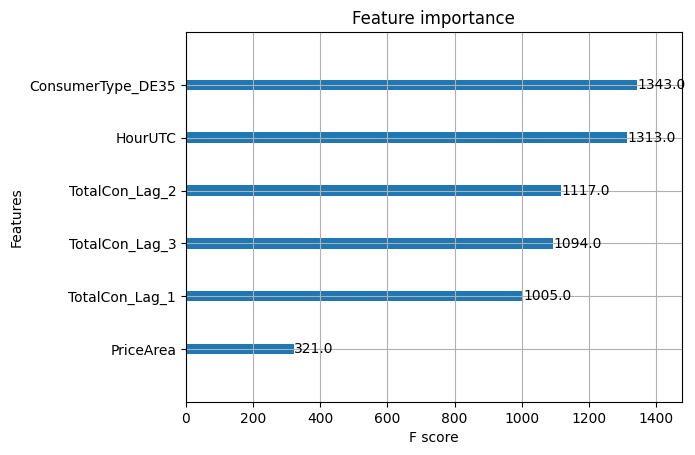

In [63]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Visualize feature importance (if needed)
xgb.plot_importance(model)
plt.show()

## AdaBoost Regressor

## ARIMA
Time series Analysis

## Prophet

## LSTM
